In [4]:
!kaggle competitions download -c spaceship-titanic

100%|█████████████████████████████████████████| 299k/299k [00:01<00:00, 292kB/s]
100%|█████████████████████████████████████████| 299k/299k [00:01<00:00, 292kB/s]


In [5]:
!mkdir data && tar -xf spaceship-titanic.zip -C data

In [6]:
rm spaceship-titanic.zip

In [7]:
import numpy as np
import pandas as pd
import os
import torch

for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/test.csv
data/train.csv
data/sample_submission.csv


In [13]:
df = pd.read_csv("data/train.csv")

df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [31]:
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [44]:
df.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

# Exploratory Data Analysis:

In [46]:
df['Transported'].value_counts('False')

Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64

<Axes: xlabel='Age', ylabel='Count'>

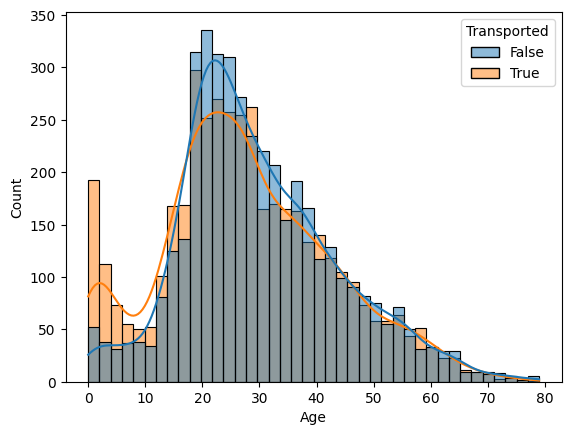

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data=df, x='Age', hue='Transported', binwidth=2, kde=True)

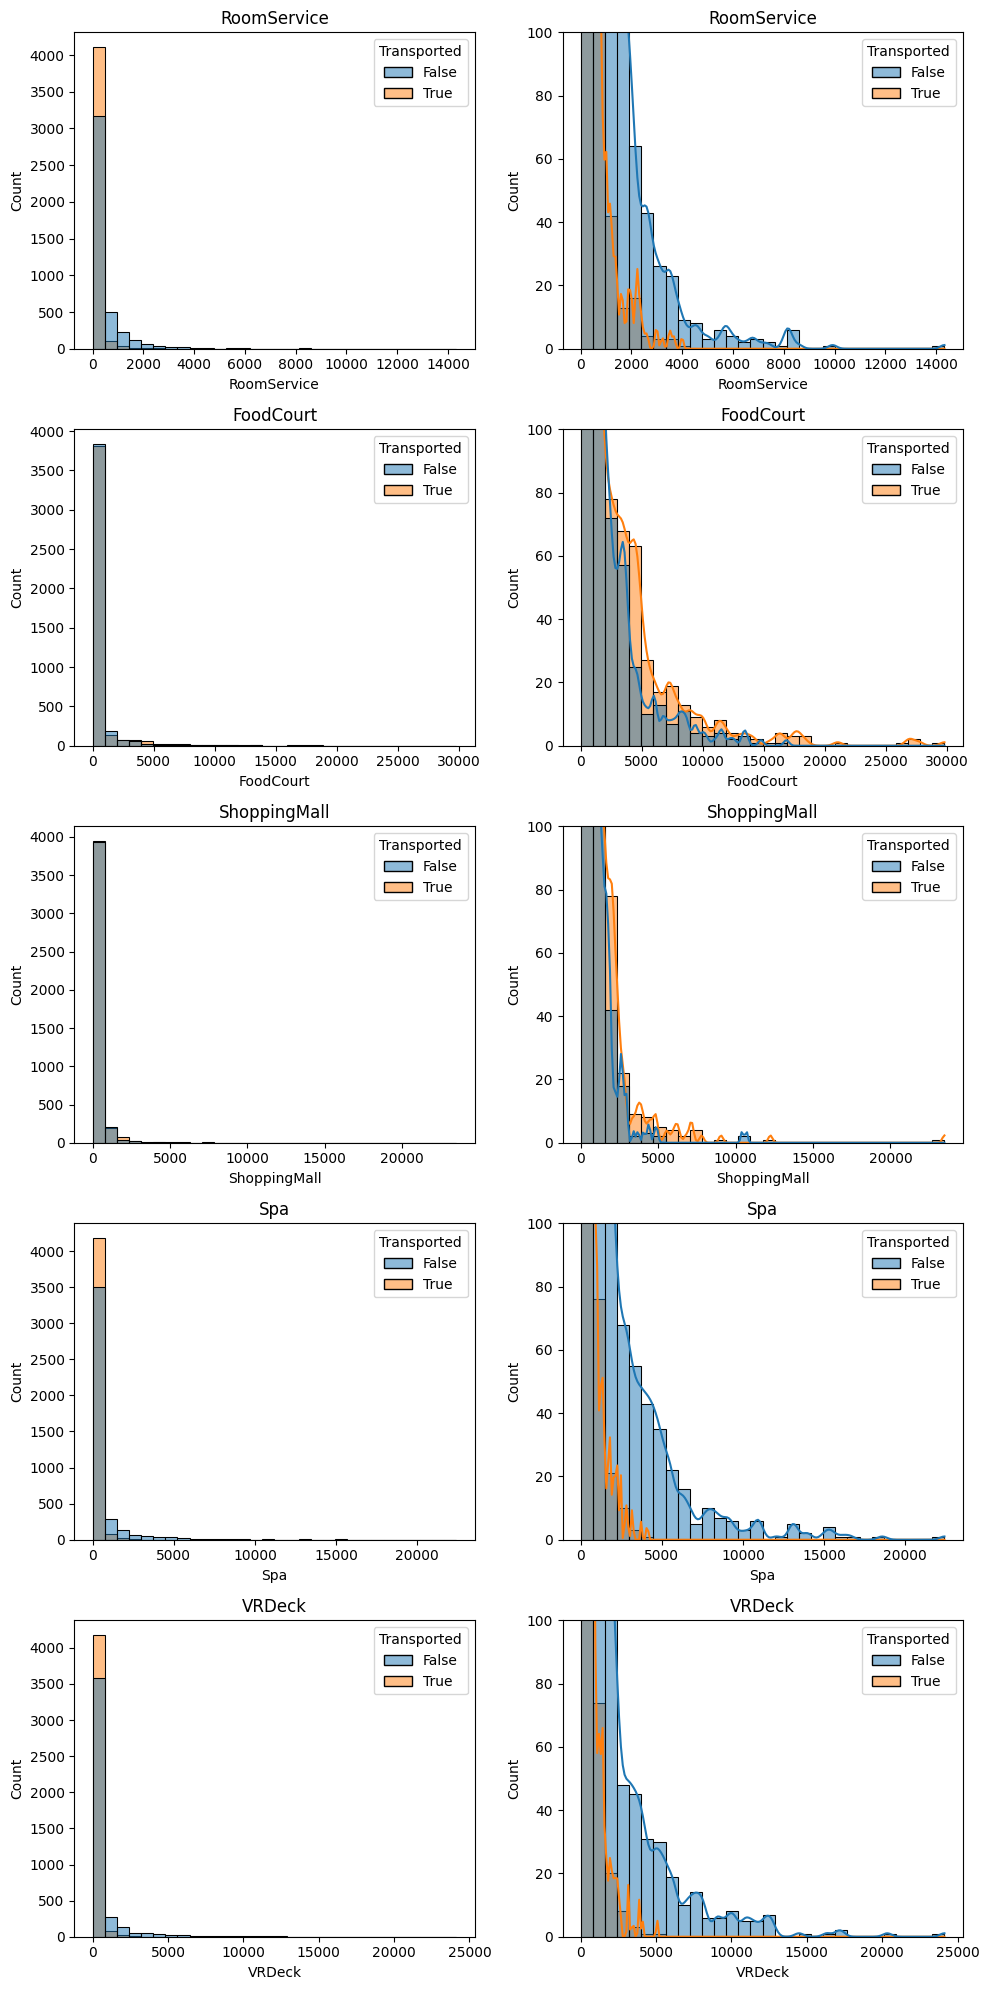

In [58]:
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Plot expenditure features
fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(exp_feats):
    # Left plot
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=df, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)
    
    # Right plot (truncated)
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=df, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout()
plt.show()



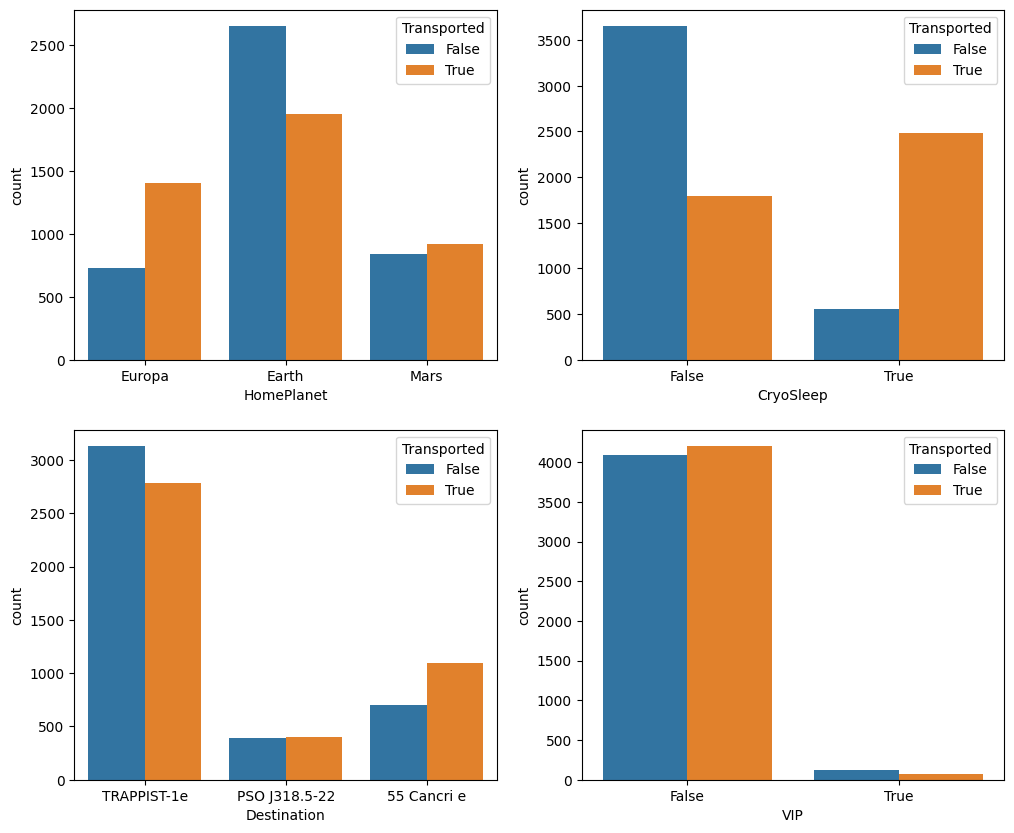

In [59]:
import seaborn as sns

fig, axarr = plt.subplots(2, 2, figsize=(12, 10))
sns.countplot(x='HomePlanet', hue = 'Transported',data = df, ax=axarr[0][0])
sns.countplot(x='CryoSleep', hue = 'Transported',data = df, ax=axarr[0][1])
sns.countplot(x='Destination', hue = 'Transported',data = df, ax=axarr[1][0])
sns.countplot(x='VIP', hue = 'Transported',data = df, ax=axarr[1][1]);

### Notes from EDA:
- Create a new feature that indicates whether the passanger is a child, adolescent or adult.
- Create a new feature that tracks the total expenditure across all 5 amenities.
- Create a binary feature to indicate if the person has spent $0.
- We might consider dropping the VIP column to prevent overfitting.

**Social Grouping:**
- We can extract the group and group size from the PassengerId feature.
- We can extract the deck, number and side from the cabin feature.
- We could extract the surname from the name feature to identify families.


# Feature engineering

/var/folders/zs/5d7ptdmj0cg4xl426n5xdzt00000gn/T/ipykernel_44931/4141267692.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Age_0-12' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  train.loc[train['Age']<=12,'Age_group']='Age_0-12'


Text(0.5, 1.0, 'Age group distribution')

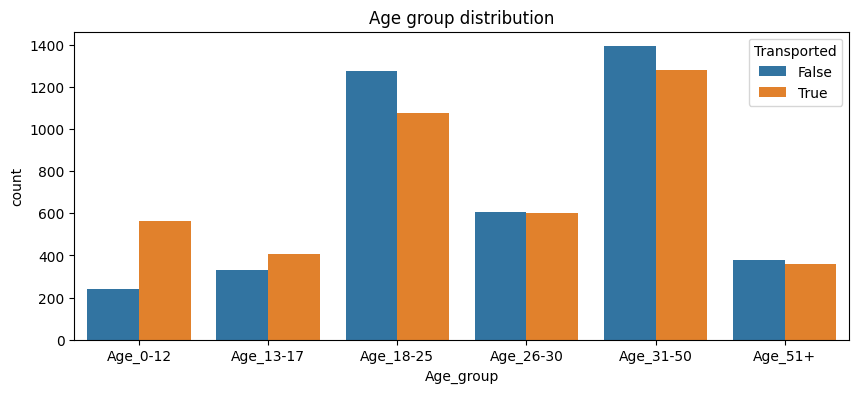

In [60]:
train = df

train['Age_group']=np.nan
train.loc[train['Age']<=12,'Age_group']='Age_0-12'
train.loc[(train['Age']>12) & (train['Age']<18),'Age_group']='Age_13-17'
train.loc[(train['Age']>=18) & (train['Age']<=25),'Age_group']='Age_18-25'
train.loc[(train['Age']>25) & (train['Age']<=30),'Age_group']='Age_26-30'
train.loc[(train['Age']>30) & (train['Age']<=50),'Age_group']='Age_31-50'
train.loc[train['Age']>50,'Age_group']='Age_51+'

plt.figure(figsize=(10,4))
g=sns.countplot(data=train, x='Age_group', hue='Transported', order=['Age_0-12','Age_13-17','Age_18-25','Age_26-30','Age_31-50','Age_51+'])
plt.title('Age group distribution')

In [61]:
train['Expenditure']=train[exp_feats].sum(axis=1)
train['No_spending']=(train['Expenditure']==0).astype(int)



,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Age_group
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,Age_31-50
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,Age_18-25
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,Age_51+
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,Age_31-50
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,Age_13-17
